![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [241]:
import warnings
warnings.filterwarnings('ignore')

In [242]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, export_graphviz


import plotly.express as px

In [243]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()
#print(type(bikes))

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [244]:
# Celda 1.1
bikes.groupby('workingday').total.mean()
bikeswd=bikes['workingday']
bikeswd=bikeswd.to_frame(name='workingday')
bikeswd['workingday']=bikeswd['workingday'].astype(str)


print('-------- Estadísticas variabel workingday-----------')

print('--- Descripción---')
estadisticas1=bikeswd.describe(include = 'all')

print(estadisticas1)
print('--- Valores faltantes---')

print(type(bikeswd))

percent_missing = bikeswd.isna().sum() * 100 / len(bikeswd)
missing_value_df = pd.DataFrame({'#_faltantes': bikeswd.isna().sum(),
                                 '%_faltantes': percent_missing})

print(missing_value_df)

print('--- Histograma---')

fig = px.histogram(bikes, x=bikes['workingday'])
fig.show()

-------- Estadísticas variabel workingday-----------
--- Descripción---
       workingday
count       10886
unique          2
top             1
freq         7412
--- Valores faltantes---
<class 'pandas.core.frame.DataFrame'>
            #_faltantes  %_faltantes
workingday            0          0.0
--- Histograma---


In [245]:
# Celda 1.2
bikeshour=bikes['hour']
bikestotal=bikes['total']
bikes.groupby('hour').total.mean()
bikeshour=bikeshour.to_frame(name='hour')
bikestotal=bikestotal.to_frame(name='total')


print('-------- Estadísticas variabel workingday-----------')

print('--- Descripción---')
estadisticas2=bikeshour.describe(include = 'all')
print(estadisticas2)
estadisticas3=bikestotal.describe(include = 'all')

print('--- Valores faltantes---')

percent_missing = bikeshour.isna().sum() * 100 / len(bikeshour)
missing_value_df = pd.DataFrame({'#_faltantes': bikeshour.isna().sum(),
                                 '%_faltantes': percent_missing})

print(missing_value_df)

percent_missing = bikestotal.isna().sum() * 100 / len(bikestotal)
missing_value_df = pd.DataFrame({'#_faltantes': bikestotal.isna().sum(),
                                 '%_faltantes': percent_missing})

print(missing_value_df)

print('--- Histograma---')

fig = px.histogram(bikes, x=bikes['hour'])
fig.show()


fig = px.histogram(bikes, x=bikes['total'])
fig.show()

-------- Estadísticas variabel workingday-----------
--- Descripción---
               hour
count  10886.000000
mean      11.541613
std        6.915838
min        0.000000
25%        6.000000
50%       12.000000
75%       18.000000
max       23.000000
--- Valores faltantes---
      #_faltantes  %_faltantes
hour            0          0.0
       #_faltantes  %_faltantes
total            0          0.0
--- Histograma---


COMENTARIOS DE ANÁLISIS:

* Variable workingday: la mayoría de registros se hacen en días laborales con un valor de 7412 registros.
* Los registros están balanceados por horas del día con pequeñas disminuciones entre las horas 2, 3 y 4.
* Para el caso de la variable hour se muestran los datos de percentiles, max, min, desviación estándar, media y cuenta.
* Para el caso de la variable workingday se saco la tabla de valores únicos, tope y frecuencia.
* No existen valores faltantes en ninguno de las variables hour ni workingday.

### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

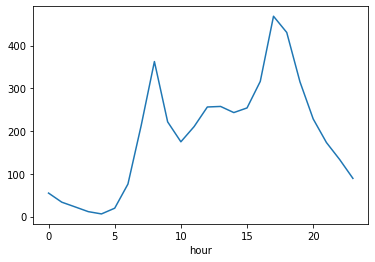

In [246]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

------- Rentas promedio cuando workingday igual a cero--------------


<AxesSubplot:xlabel='hour'>

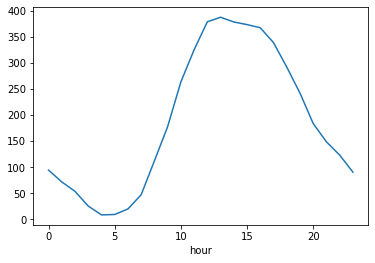

In [247]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 

print('------- Rentas promedio cuando workingday igual a cero--------------')
(bikes.loc[bikes['workingday']==0]).groupby('hour').total.mean().plot()


------- Rentas promedio cuando workingday igual a uno--------------


<AxesSubplot:xlabel='hour'>

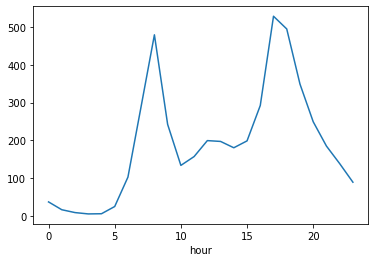

In [248]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 

print('------- Rentas promedio cuando workingday igual a uno--------------')
(bikes.loc[bikes['workingday']==1]).groupby('hour').total.mean().plot()


COMENTARIOS DE ANÁLISIS:

* Se observa que ne la gráfica donde el workingday es cero, el flujo de alquiler empieza a crecer de manera constante y llega a su máximo hacia las 10am, se mantiene más o menos constante hasta las 3:30pm y después empieza a bajar también de manera constantes.
* En la gráfica en la que el workingday es uno, el flujo tiene un pico más o menos a las 8:00am y después un pico más o menos a las 5pm. El resto del tiempo el uso de las bicicletas es bajo aunque estable entre 10am y 3pm.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [249]:
# Celda 3
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = bikes[['hour','workingday']]
y = bikes[['total']]

regresion = LinearRegression().fit(X, y)
score=regresion.score(X, y)
print('Valor Score')
print(score)
print('Coeficientes B1 y B2')
Coeficientes= regresion.coef_
print(Coeficientes)
print('Intercepto')
Intercepto=regresion.intercept_
print(Intercepto)


#Para comparar
XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)
regresion = LinearRegression().fit(XTrain, yTrain)
yPred = regresion.predict(XTest)
print("-----------")
print("Métrica R2: " + str(metrics.r2_score(yTest, yPred)))

Valor Score
0.16059115011434855
Coeficientes B1 y B2
[[10.49206282  4.07248627]]
Intercepto
[67.70595026]
-----------
Métrica R2: 0.1535707452344982


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [250]:
print(bikes['total'].describe())
print(bikes['hour'].describe())
print(bikes['workingday'].describe())
print(bikes['hour'])
print(bikes['total'])
print(bikes['workingday'])
print(bikes['workingday'].unique())
print(len(bikes['workingday'].unique()))

count    10886.000000
mean       191.574132
std        181.144454
min          1.000000
25%         42.000000
50%        145.000000
75%        284.000000
max        977.000000
Name: total, dtype: float64
count    10886.000000
mean        11.541613
std          6.915838
min          0.000000
25%          6.000000
50%         12.000000
75%         18.000000
max         23.000000
Name: hour, dtype: float64
count    10886.000000
mean         0.680875
std          0.466159
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          1.000000
Name: workingday, dtype: float64
datetime
2011-01-01 00:00:00     0
2011-01-01 01:00:00     1
2011-01-01 02:00:00     2
2011-01-01 03:00:00     3
2011-01-01 04:00:00     4
                       ..
2012-12-19 19:00:00    19
2012-12-19 20:00:00    20
2012-12-19 21:00:00    21
2012-12-19 22:00:00    22
2012-12-19 23:00:00    23
Name: hour, Length: 10886, dtype: int64
datetime
2011-01-01 00:00:00     16
2011-01-01 01

In [257]:
# Celda 4
# Selección de variables predictoras
X = bikes[['hour','workingday']]
print(X)
features = range(X.shape[1])
print(features)

y=bikes[['total']]

# Definición de parámetros y criterios de parada
max_depth = None
num_pct = 12
max_features = None
min_gain=0.001

print(X)

features = range(X.shape[1])
print(features)

                     hour  workingday
datetime                             
2011-01-01 00:00:00     0           0
2011-01-01 01:00:00     1           0
2011-01-01 02:00:00     2           0
2011-01-01 03:00:00     3           0
2011-01-01 04:00:00     4           0
...                   ...         ...
2012-12-19 19:00:00    19           1
2012-12-19 20:00:00    20           1
2012-12-19 21:00:00    21           1
2012-12-19 22:00:00    22           1
2012-12-19 23:00:00    23           1

[10886 rows x 2 columns]
range(0, 2)
                     hour  workingday
datetime                             
2011-01-01 00:00:00     0           0
2011-01-01 01:00:00     1           0
2011-01-01 02:00:00     2           0
2011-01-01 03:00:00     3           0
2011-01-01 04:00:00     4           0
...                   ...         ...
2012-12-19 19:00:00    19           1
2012-12-19 20:00:00    20           1
2012-12-19 21:00:00    21           1
2012-12-19 22:00:00    22           1
2012-12-19 2

In [258]:
# Impresión variable a usar (Hour)
j = 0
print(X.columns[j])

hour


In [259]:
#Definición de la métrica para cálcular el error
def errorcuadra (Ytest, Ypred):
    i=0
    errorcua=0
    #print('----------------- Ytest-------------')
    #print(Ytest)
    #print(len(Ytest))
    #print(type(Ytest))
    #print('----------------- Ypred-------------')
    #print(Ypred)
    #print(type(Ypred))
    #print(len(Ypred))
    #print(Ypred)
    #print('hasta aquí lo está haciendo bien....????')
    Ytest=Ytest.squeeze()
    while i<len(Ytest):
        error=Ytest[i]-Ypred
        error=error*error
        errorcua=errorcua+error
        i=i+1
    errorcua=pow(errorcua,0.5)/len(Ytest)
    return errorcua

In [260]:
def sumaerrorcuadra(X_col, y, split):
    
    filter_l = X_col < split
    y_l = y.loc[filter_l]
    n_l = y_l.shape[0]
    mean_l=y_l.sum()/n_l
    y_r = y.loc[~filter_l]
    n_r = y_r.shape[0]
    mean_r=y_l.sum()/n_r
    errorcuadra_l = errorcuadra(y_l,mean_l)
    errorcuadra_r = errorcuadra(y_r,mean_r)
    sumaerror=errorcuadra_l+errorcuadra_r
    return sumaerror

print(sumaerrorcuadra(bikes['hour'],bikes['total'],10))
print(sumaerrorcuadra(bikes['workingday'],bikes['total'],1))

5.3991580633838465
5.410844305711543


In [261]:
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y, num_pct=10):
    best_s = [0,0,1000000000]  # j,split, error
    
    features = range(X.shape[1])
    for j in features:
        splits = np.percentile(X.iloc[:, j], np.arange(0, 100, 100.0 / (num_pct+1)).tolist())
        splits = np.unique(splits)[1:]
        print(splits)
        #best_s[2]= sumaerrorcuadra(X.iloc[:, 0], y, splits[0])
        # Para cada partición        
        for split in splits:
            errorsplit = sumaerrorcuadra(X.iloc[:, j], y, split)
            #print('split: '+str(split))
            #print (errorsplit)
            
            if (errorsplit < best_s[2]).bool():
                best_s = [j,split, errorsplit]
            #print(best_s[2])
        #print('variable para corte es '+str(best_s[0]))
        #print('el sitio del corte es '+str(best_s[1]))
        #print('el error de ese corte es '+str(best_s[2]))
    print('la mejor variable de partida es '+str(best_s[0]))
    print('el sitio del corte es '+str(best_s[1]))
    print('el error de esa variable en ese corte es '+str(best_s[2]))
        
    return best_s


# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol
def tree_grow(X, y, nodo,level=0, max_nodos=8, max_depth=None, num_pct=10):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, mse=0)
        return tree
    print('nodo es: '+str(nodo))
    j,split, MSE = best_split(X,y, num_pct)
    
    # Guardar el árbol y estimar la predicción
    y_pred = y.mean()
    
    tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], mse=MSE)
    # Revisar el criterio de parada 
    #if gain < min_gain:
    #    return tree
    if nodo >= max_nodos:
        return tree
    if max_depth is not None:
        if level >= max_depth:
            return tree   
    
    # Continuar creando la partición
    filter_l = X.iloc[:, j] < split
    X_l, y_l = X.loc[filter_l], y.loc[filter_l]
    X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
    tree['split'] = [j, split]

    # Siguiente iteración para cada partición
    
    tree['sl'] = tree_grow(X_l, y_l,nodo+1, level + 1,max_nodos=max_nodos, max_depth=max_depth, num_pct=num_pct)
    tree['sr'] = tree_grow(X_r, y_r,nodo+1, level + 1,max_nodos=max_nodos, max_depth=max_depth, num_pct=num_pct)
    
    return tree




In [262]:
# Aplicación de la función tree_grow
tree_grow(X, y,nodo=1, level=0, max_nodos=6, max_depth=None, num_pct=10)

nodo es: 1
[ 2.  4.  6.  8. 10. 13. 15. 17. 19. 21.]
[1.]
la mejor variable de partida es 0
el sitio del corte es 4.0
el error de esa variable en ese corte es total    3.799683
dtype: float64
nodo es: 2
[1. 2. 3.]
[1.]
la mejor variable de partida es 1
el sitio del corte es 1.0
el error de esa variable en ese corte es total    2.378722
dtype: float64
nodo es: 3
[1. 2. 3.]
[]
la mejor variable de partida es 0
el sitio del corte es 2.0
el error de esa variable en ese corte es total    5.505331
dtype: float64
nodo es: 4
[1.]
[]
la mejor variable de partida es 0
el sitio del corte es 1.0
el error de esa variable en ese corte es total    7.317264
dtype: float64
nodo es: 5
[]
[]
la mejor variable de partida es 0
el sitio del corte es 0
el error de esa variable en ese corte es 1000000000
nodo es: 6


IndexError: cannot do a non-empty take from an empty axes.

### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de clasificación y compare desempeño con el modelo del punto 3.

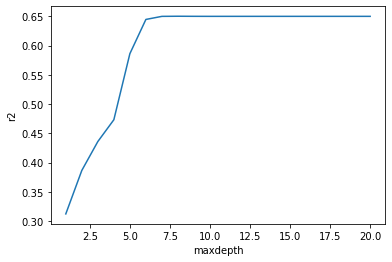

(0.6501337581022684, 8)
Métrica de desempeño R cuadrado: 0.6504671083410165


In [263]:
# Celda 5
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

XTrain, XTest, yTrain, yTest = train_test_split(X, y, test_size=0.33, random_state=0)

max_depthrange = range(1, 21)
r2scores = []

for depth in max_depthrange:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    r2scores.append(cross_val_score(clf, XTrain, yTrain, cv=10, scoring='r2').mean())
    
plt.plot(max_depthrange, r2scores)
plt.xlabel('maxdepth')
plt.ylabel('r2')
plt.show()

# Mejor R2 (desempeño) y su max_depth
best_numtree = sorted(zip(r2scores, max_depthrange))[::-1][0][1]
print(sorted(zip(r2scores, max_depthrange))[::-1][0])

#Para comparar
from sklearn.metrics import r2_score

# max_depth=8 fue el mejor, se ajusta un árbol usando este valor 
clf = DecisionTreeRegressor(max_depth=best_numtree, random_state=1)
clf.fit(XTrain, yTrain)
yPred = clf.predict(XTest)
print("Métrica de desempeño R cuadrado: " + str(r2_score(yTest, yPred)))

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [264]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()
df.describe()

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
count,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,...,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000,6000.000000
mean,358.138833,10.368667,547.428833,0.527732,0.961333,0.665823,11.874000,3.272500,4.954667,1.463167,...,0.097194,0.762009,-0.265334,-0.530531,-0.110047,0.296854,0.077178,0.343496,0.167633,0.500000
std,210.734614,2.106140,510.232776,0.148356,0.192815,0.167740,13.444103,4.262895,8.635916,4.508144,...,0.076585,0.256845,0.133800,0.294477,0.100482,0.334117,0.282790,0.186815,0.240462,0.500042
min,9.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,-1.000000,-1.000000,-1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000
25%,175.000000,9.000000,231.000000,0.465950,1.000000,0.619624,4.000000,1.000000,1.000000,0.000000,...,0.050000,0.600000,-0.340000,-0.714286,-0.125000,0.000000,0.000000,0.166667,0.000000,0.000000
50%,345.000000,10.000000,391.000000,0.541477,1.000000,0.689119,8.000000,2.000000,1.000000,0.000000,...,0.100000,0.800000,-0.260185,-0.500000,-0.100000,0.200000,0.000000,0.500000,0.016667,0.500000
75%,544.250000,12.000000,719.000000,0.614980,1.000000,0.756237,15.000000,4.000000,7.000000,1.000000,...,0.100000,1.000000,-0.191273,-0.300000,-0.050000,0.500000,0.166667,0.500000,0.250000,1.000000
max,731.000000,19.000000,8474.000000,0.967742,1.000000,1.000000,304.000000,116.000000,111.000000,91.000000,...,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.500000,1.000000,1.000000


In [265]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']
y.mean()

0.5

In [266]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

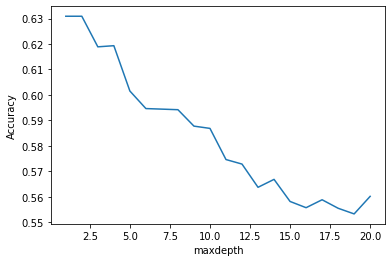

Best depth in:
2
-----------------------
Árbol de decisión
Accuracy: 0.6453333333333333
F1: 0.6448598130841121
----------------------
Regresión Logistica
Accuracy: 0.614
F1: 0.61010101010101


In [267]:
# Celda 6

#Selección de Árbol de decisión 
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

max_depth_range = range(1, 21)
accuracy_scores  = []

for depth in max_depth_range:
    clf = DecisionTreeClassifier(max_depth=depth, random_state=1)
    accuracy_scores.append(cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy').mean())
    
plt.plot(max_depth_range, accuracy_scores)
plt.xlabel('maxdepth')
plt.ylabel('Accuracy')
plt.show()

best_num_tree = sorted(zip(accuracy_scores, max_depth_range))[::-1][0][1]
print("Best depth in:")
print(best_num_tree)

#Métricas
arbol = DecisionTreeClassifier(max_depth=best_num_tree, random_state=1)
arbol.fit(X_train, y_train)
yPredArbol = arbol.predict(X_test)

print("-----------------------")
print("Árbol de decisión")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPredArbol)))
print("F1: " + str(metrics.f1_score(y_test, yPredArbol)))

reg = LogisticRegression(random_state=0).fit(X_train, y_train)
yPredReg = reg.predict(X_test)

print("----------------------")
print("Regresión Logistica")
print("Accuracy: " + str(metrics.accuracy_score(y_test, yPredReg)))
print("F1: " + str(metrics.f1_score(y_test, yPredReg)))


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [268]:
# Celda 7

print('No encuentro como se deben ingresar las 300 muestras bagged')

from sklearn.ensemble import BaggingClassifier

num_estimadores = 100

# 100 árboles de decisión con max_depth = None
maxddepthNone = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=None), n_estimators=num_estimadores, 
                           bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
# 100 árboles de decisión con max_depth = 2
maxdepth2 = BaggingClassifier(base_estimator = DecisionTreeClassifier(max_depth=2), n_estimators=num_estimadores, 
                           bootstrap =True, random_state=42, n_jobs=-1, oob_score=True)
# 100 reglog
reglog = BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=num_estimadores, 
                           bootstrap=True, random_state=42, n_jobs=-1, oob_score=True)


# Predicción y desempeño con hacer votación mayoritaria
print("------")
print("Desempeño con votación mayoritaria")

maxddepthNone.fit(X_train, y_train)
yPredmaxddepthNone = maxddepthNone.predict(X_test)
print("-------")
print("100 árboles de decisión max_depth es None")
print("Acc: " + str(metrics.accuracy_score(yPredmaxddepthNone, y_test)))
print("F1: " + str(metrics.f1_score(yPredmaxddepthNone, y_test)))

maxdepth2.fit(X_train, y_train)
yPredmd2 = maxdepth2.predict(X_test)
print("--------")
print("100 árboles de decisión max_depth es 2")
print("Acc: " + str(metrics.accuracy_score(yPredmd2, y_test)))
print("F1: " + str(metrics.f1_score(yPredmd2, y_test)))

reglog.fit(X_train, y_train)
yPredmreglog = reglog.predict(X_test)
print("--------")
print("100 regresiones logísticas")
print("Acc: " + str(metrics.accuracy_score(yPredmreglog, y_test)))
print("F1: " + str(metrics.f1_score(yPredmreglog, y_test)))


No encuentro como se deben ingresar las 300 muestras bagged
------
Desempeño con votación mayoritaria
-------
100 árboles de decisión max_depth es None
Acc: 0.64
F1: 0.642384105960265
--------
100 árboles de decisión max_depth es 2
Acc: 0.6446666666666667
F1: 0.6439545758183033
--------
100 regresiones logísticas
Acc: 0.6173333333333333
F1: 0.6126855600539811


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [271]:
# Celda 8

# 100 árboles de decisión donde max_depth = None
errors_none = np.zeros(maxddepthNone.n_estimators)
y_pred_all_none = np.zeros((X_test.shape[0], maxddepthNone.n_estimators))

# 100 árboles de decisión donde max_depth = 2
errors_2 = np.zeros(maxdepth2.n_estimators)
y_pred_all_2 = np.zeros((X_test.shape[0], maxdepth2.n_estimators))

# 100 regresiones logísticas
errors_rl = np.zeros(reglog.n_estimators)
y_pred_all_rl = np.zeros((X_test.shape[0], reglog.n_estimators))

for i in range(num_estimadores):
    
    #100 árboles de decisión donde max_depth = None
    oob_sample = ~maxddepthNone.estimators_samples_[i]
    y_pred_ = maxddepthNone.estimators_[i].predict(X_train.values[oob_sample])
    errors_none[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_none[:, i] = maxddepthNone.estimators_[i].predict(X_test)
    
    # 100 árboles de decisión donde max_depth = 2
    oob_sample = ~maxdepth2.estimators_samples_[i]
    y_pred_ = maxdepth2.estimators_[i].predict(X_train.values[oob_sample])
    errors_2[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_2[:, i] = maxdepth2.estimators_[i].predict(X_test)
    
    # 100 regresiones logísticas
    oob_sample = ~reglog.estimators_samples_[i]
    y_pred_ = reglog.estimators_[i].predict(X_train.values[oob_sample])
    errors_rl[i] = metrics.accuracy_score(y_pred_, y_train.values[oob_sample])
    y_pred_all_rl[:, i] = reglog.estimators_[i].predict(X_test)

# Desempeño al hacer votación ponderada
print("-------------------------------------")
print("Desempeño con votación ponderada")

#100 árboles de decisión donde max_depth = None
alpha = (1 - errors_none) / (1 - errors_none).sum()
yPredNone = (np.sum(y_pred_all_none * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = None")
print("Accuracy: " + str(metrics.accuracy_score(yPredNone, y_test)))
print("F1: " + str(metrics.f1_score(yPredNone, y_test)))

# 100 árboles de decisión donde max_depth = 2
alpha = (1 - errors_2) / (1 - errors_2).sum()
yPred2 = (np.sum(y_pred_all_2 * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 árboles de decisión donde max_depth = 2")
print("Accuracy: " + str(metrics.accuracy_score(yPred2, y_test)))
print("F1: " + str(metrics.f1_score(yPred2, y_test)))

# 100 regresiones logísticas
alpha = (1 - errors_rl) / (1 - errors_rl).sum()
yPredrl = (np.sum(y_pred_all_rl * alpha, axis=1) >= 0.5).astype(np.int)
print("--------------------------------------------")
print("100 regresiones logísticas")
print("Accuracy: " + str(metrics.accuracy_score(yPredrl, y_test)))
print("F1: " + str(metrics.f1_score(yPredrl, y_test)))

-------------------------------------
Desempeño con votación ponderada
--------------------------------------------
100 árboles de decisión donde max_depth = None
Accuracy: 0.6453333333333333
F1: 0.6513761467889909
--------------------------------------------
100 árboles de decisión donde max_depth = 2
Accuracy: 0.6453333333333333
F1: 0.6448598130841121
--------------------------------------------
100 regresiones logísticas
Accuracy: 0.6173333333333333
F1: 0.6132075471698114


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

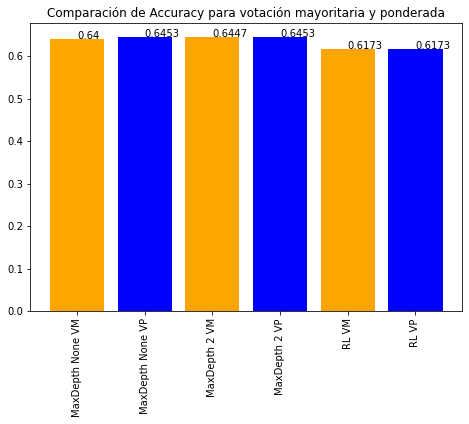

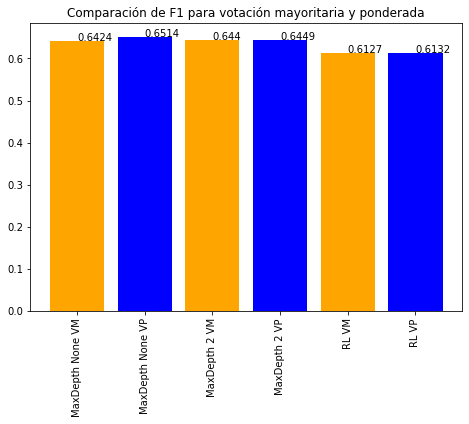

In [278]:
# Celda 9

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de Accuracy para votación mayoritaria y ponderada")
ejeX = ['MaxDepth None VM','MaxDepth None VP','MaxDepth 2 VM','MaxDepth 2 VP','RL VM','RL VP']
ejeY = [round(metrics.accuracy_score(yPredmaxddepthNone, y_test),4),
       round(metrics.accuracy_score(yPredNone, y_test),4),
       round(metrics.accuracy_score(yPredmd2, y_test),4),
       round(metrics.accuracy_score(yPred2, y_test),4),
       round(metrics.accuracy_score(yPredmreglog, y_test),4),
       round(metrics.accuracy_score(yPredrl, y_test),4)]

cc=['colors']*len(ejeX)
for n,val in enumerate(ejeX):
    if n%2:
        cc[n]='blue'
    else:
        cc[n]='orange'

ax.bar(ejeX,ejeY, color = cc)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.set_title("Comparación de F1 para votación mayoritaria y ponderada")
ejeX = ['MaxDepth None VM','MaxDepth None VP','MaxDepth 2 VM','MaxDepth 2 VP','RL VM','RL VP']
ejeY = [round(metrics.f1_score(yPredmaxddepthNone, y_test),4),
       round(metrics.f1_score(yPredNone, y_test),4),
       round(metrics.f1_score(yPredmd2, y_test),4),
       round(metrics.f1_score(yPred2, y_test),4),
       round(metrics.f1_score(yPredmreglog, y_test),4),
       round(metrics.f1_score(yPredrl, y_test),4)]
ax.bar(ejeX,ejeY, color = cc)
def addlabels(x,y,plotP):
    for i in range(len(x)):
        plotP.text(i,y[i],y[i])
addlabels(ejeX,ejeY,plt)
plt.xticks(rotation=90)
plt.show()

Los resultados en ambos casos se consideran similares, se considera mejor los modelos con árboles que los de regresión logística, con una muy pequeña mejoría en los de votación ponderada.